# Projet de modélisation d'un mix énergétique issu 100% d'ENR

## VI. Profils de production des vre

### Imports

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import csv
from data_formatting import Import_data

In [2]:
vre2006 = pd.read_csv("inputs/vre_profiles2006.csv", header=None)
vre2006.columns = ["vre", "heure", "prod"]

vre2006["vre"][8759]  #dernier offshore
vre2006["vre"][8760]  #1er     onshore
vre2006["vre"][17519] #dernier onshore
vre2006["vre"][17520] #1er     pv
vre2006["vre"][26279] #dernier pv
vre2006

,vre,heure,prod
0,offshore,0,0.865143
1,offshore,1,0.880000
2,offshore,2,0.880000
3,offshore,3,0.873429
4,offshore,4,0.852000
...,...,...,...
26275,pv,8755,0.000000
26276,pv,8756,0.000000
26277,pv,8757,0.000000
26278,pv,8758,0.000000


In [3]:
vre2000,vre2001,vre2002,vre2003,vre2004,vre2005,vre2006,vre2007,vre2008,vre2009,vre2010,vre2011,vre2012,vre2013,vre2014,vre2015,vre2016,vre2017=Import_data()

### 1. Utils

#### 1.1 Construction des profils

In [4]:
# Moyenne de chaque heure de la journée sur un an
# Vecteur de 24 (nb d'heures)

def Moyenne_jour(profil):
    heures, jours = np.shape(profil)
    moy_j = np.zeros(heures)
    for j in range(jours):
        for h in range(heures):
            moy_j[h] += profil[h,j]
    moy_j = moy_j/jours
    return moy_j

In [5]:
# Moyenne de la production d'une semaine sur un an
# Matrice 7 x nb de semaines dans le profil en argument

def Moyenne_semaine(profil):
    jours, semaines = np.shape(profil)
    moy_semaine = np.zeros(semaines)
    for s in range(semaines):
        for j in range(jours):
            moy_semaine[s] += profil[j,s]
    moy_semaine = moy_semaine/jours
    return moy_semaine

In [6]:
# Moyenne de la production d'une semaine sur chaque saison 
# Matrice 7 x nb semaines de chaque saison

def Moyenne_saison(profil, vre):
    if vre=="offshore":
        n=0
    elif vre=="onshore":
        n=8760
    elif vre=="pv":
        n=17520
        
    profil_semaine = np.zeros((7,52))
    for m in range(52):
        for j in range(7):
            for h in range(24):
                profil_semaine[j-1,m-1] += [profil[2][24*(j+m*7)+h+1+n]]

    #Hiver :  11+1  (11 premieres semaines de l'annee + la derniere semaine de l'annee)
    hiver_m = np.zeros((7,12))
    hiver_m[:,:11] = profil_semaine[:,:11]
    hiver_m[:,-1] = profil_semaine[:,-1]
    hiver_moy = Moyenne_semaine(hiver_m)
    
    #Printemps :  13
    printemps_m = np.zeros((7,13))
    printemps_m = profil_semaine[:,11:24]
    printemps_moy = Moyenne_semaine(printemps_m)

    #Eté :  14
    ete_m = np.zeros((7,14))
    ete_m = profil_semaine[:,24:38]
    ete_moy = Moyenne_semaine(ete_m)

    #Automne :  13
    automne_m = np.zeros((7,13))
    automne_m = profil_semaine[:,38:51]
    automne_moy = Moyenne_semaine(automne_m)

    return printemps_moy, automne_moy, ete_moy, hiver_moy

In [7]:
# Moyenne de production de chaque semaine de l'année

def Moyenne_annee(profil, vre):
    if vre=="offshore":
        n=0
    elif vre=="onshore":
        n=8760
    elif vre=="pv":
        n=17520
        
    profil_semaine = np.zeros((7,52))
    for m in range(52):
        for j in range(7):
            for h in range(24):
                profil_semaine[j-1,m-1] += [profil[2][24*(j+m*7)+h+1+n]]
    
    return Moyenne_semaine(profil_semaine)

#### 1.2 Affichages des profils

In [8]:
# Affichage du profil de production d'une journée calculé avec les données d'une année entière

def Profils_journaliers(profil, vre, annee, verbose=False):
    if vre=="offshore":
        n=0
    elif vre=="onshore":
        n=8760
    elif vre=="pv":
        n=17519
        
    profil_jour = np.zeros((24,365))
    for j in range(365):
        for i in range(24):
            profil_jour[i,j] += [profil[2][(i+1)+j*24+n]]
            
    moy_jour = Moyenne_jour(profil_jour)
    plt.plot(moy_jour, label=annee)
    plt.title("Daily production profil  : " + vre)
    plt.ylabel('Power production')
    plt.xlabel("Hours")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    
    if verbose :
        return profil_jour

In [9]:
# Affichage du profil de production d'une semaine sur 4 saisons calculé avec les données d'une année entière

def Profils_saisonniers(profil, vre, annee=0, saison="", verbose=False):
    
    printemps_moy, automne_moy, ete_moy, hiver_moy = Moyenne_saison(profil, vre)
    
    if saison=="tout":   
        plt.plot(hiver_moy, label="winter")
        plt.plot(ete_moy, label="summer")
        plt.plot(automne_moy, label="autumn")
        plt.plot(printemps_moy, label="spring")
        plt.title("Seasonal production profiles : " + vre)
        
    elif saison=="printemps":
        plt.plot(printemps_moy, label=annee)
        plt.title("Profil " + "pintanier" + " de la production par semaine de la technologie : " + vre)
        
    elif saison=="ete":
        plt.plot(ete_moy, label=annee)
        plt.title("Profil " + "estival" + " de la production par semaine de la technologie : " + vre)
        
    elif saison=="automne":
        plt.plot(automne_moy, label=annee)
        plt.title("Profil " + "automnal" + " de la production par semaine de la technologie : " + vre)
        
    elif saison=="hiver":
        plt.plot(hiver_moy, label=annee)
        plt.title("Profil " + "hivernal" + " de la production par semaine de la technologie : " + vre)
    
    plt.xlabel("Weeks of the season")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    
    if verbose:
        return moy_hiver,moy_printemps,moy_ete,moy_automne

In [10]:
# Affichage de la production de chaque semaine de l'année

def Profils_annuels(profil, vre, annee, verbose=False):
    Profil_annuel = Moyenne_annee(profil, vre)
    plt.plot(Profil_annuel, label=annee)
    plt.title("Annual profile : " + vre)
    plt.xlabel("Weeks")
    plt.ylabel("Power production")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

#### 1.3 Affichages des profils sur plusieurs années

In [11]:
# Affichage du profil journalier des vre avec les données de plusieurs années

def Affichage_annees(vre, Profils, saison = ""):
    Profils(vre2017, vre, "2017", saison)
    Profils(vre2016, vre, "2016", saison)
    Profils(vre2015, vre, "2015", saison)
    Profils(vre2014, vre, "2014", saison)
    Profils(vre2013, vre, "2013", saison)
    Profils(vre2012, vre, "2012", saison)
    Profils(vre2011, vre, "2011", saison)
    Profils(vre2010, vre, "2010", saison)

### 2. Profils de l'éolien offshore sur 2006

#### 2.1 Profil journalier de l'éolien offshore

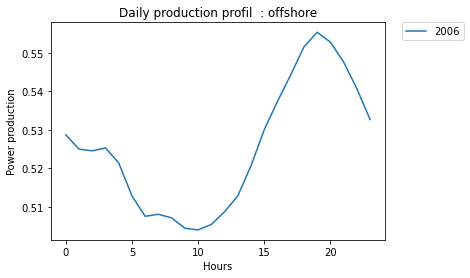

In [12]:
poff = Profils_journaliers(vre2006, "offshore", "2006", True)

In [13]:
np.shape(poff)

(24, 365)

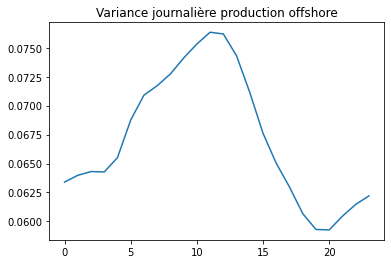

In [14]:
def Variance_profil(profil):
    var = np.zeros(24)
    for i in range(24):
        var[i] = np.var(profil[i][:])
    return var

var_off = Variance_profil(poff)
plt.plot(var_off)
plt.title('Variance journalière production offshore')
plt.show()

#### 2.2 Profils saisonniers de l'éolien offshore

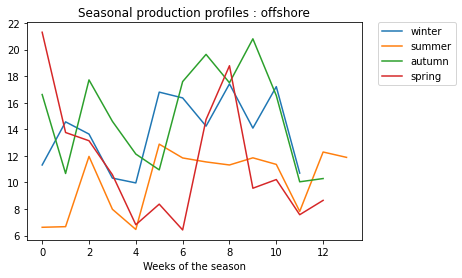

In [15]:
Profils_saisonniers(vre2006, "offshore", saison="tout")

#### 2.3 Profil annuel de l'éolien offshore

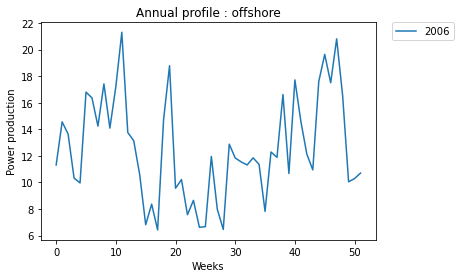

In [16]:
Profils_annuels(vre2006, "offshore", "2006")

### 3. Profils de l'éolien onshore

#### 3.1 Profil journalier de l'éolien onshore

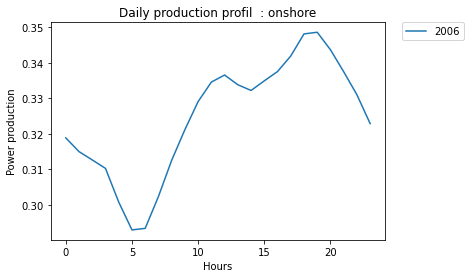

In [17]:
pon = Profils_journaliers(vre2006, "onshore", "2006", True)

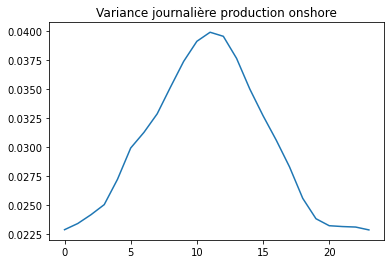

In [18]:
var_on = Variance_profil(pon)
plt.plot(var_on)
plt.title('Variance journalière production onshore')
plt.show()

#### 3.2 Profils saisonniers de l'éolien onshore

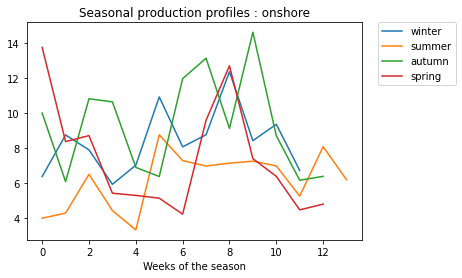

In [19]:
Profils_saisonniers(vre2006, "onshore", saison="tout")

#### 3.3 Profil annuel de l'éolien onshore

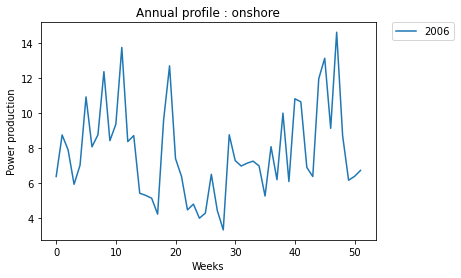

In [20]:
Profils_annuels(vre2006, "onshore", "2006")

### 4. Profils du solaire

#### 4.1 Profil journalier du solaire 

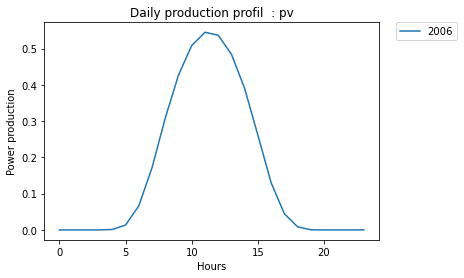

In [21]:
ppv = Profils_journaliers(vre2006, "pv", "2006", True)

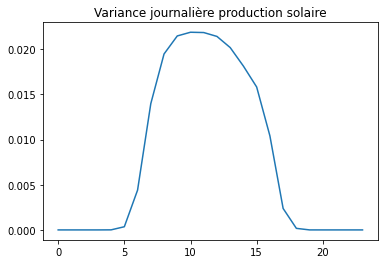

In [22]:
var_pv = Variance_profil(ppv)
plt.plot(var_pv)
plt.title('Variance journalière production solaire')
plt.show()

#### 4.2 Profils saisonniers du solaire

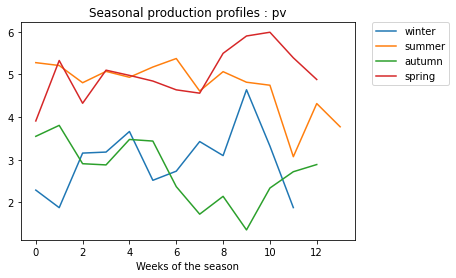

In [23]:
Profils_saisonniers(vre2006, "pv", saison="tout")

#### 4.3 Profil annuel du solaire

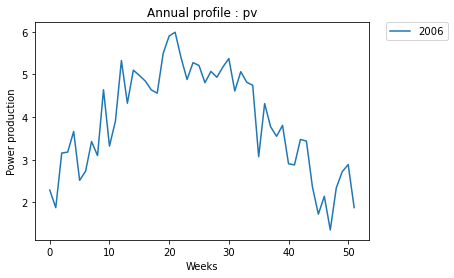

In [24]:
Profils_annuels(vre2006, "pv", "2006")

### 5. Profils sur plusieurs années

#### 5.1 Profils offshore

##### 5.1.1 Profils offshore journaliers

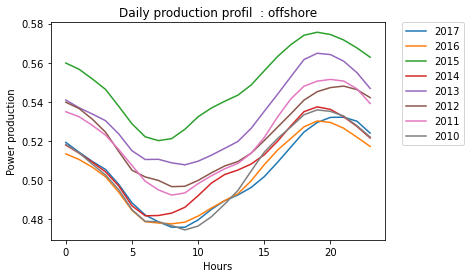

In [25]:
Affichage_annees("offshore", Profils_journaliers)

##### 5.1.2 Profils offshore saisonniers

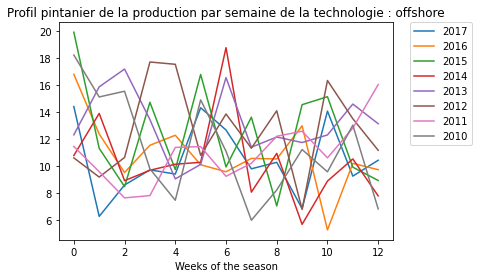

In [26]:
Affichage_annees("offshore", Profils_saisonniers, "printemps")

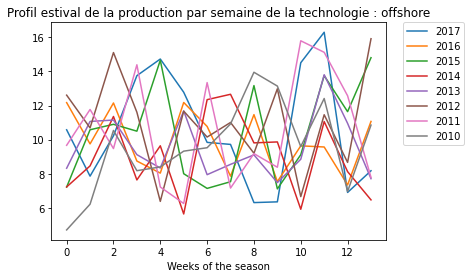

In [27]:
Affichage_annees("offshore", Profils_saisonniers, "ete")

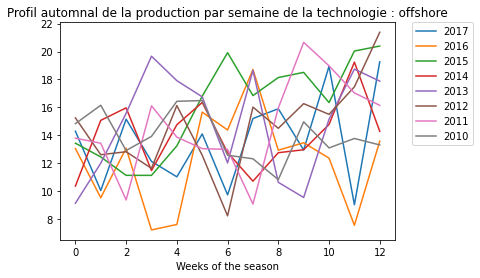

In [28]:
Affichage_annees("offshore", Profils_saisonniers, "automne")

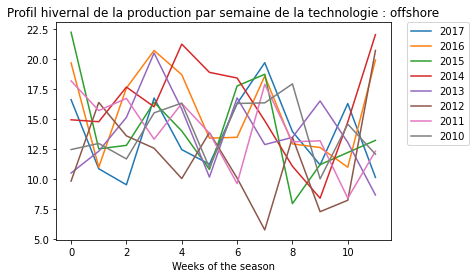

In [29]:
Affichage_annees("offshore", Profils_saisonniers, "hiver")

##### 5.1.3 Profils offshore annuels

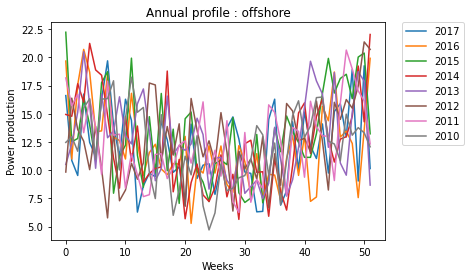

In [30]:
Affichage_annees("offshore", Profils_annuels)

#### 5.2. Profils onshore

##### 5.2.1 Profils onshore journaliers

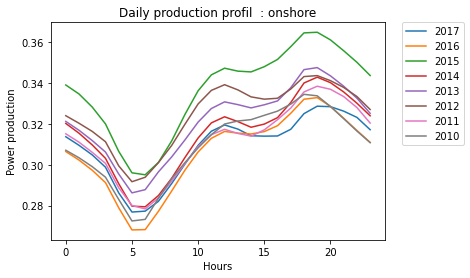

In [31]:
Affichage_annees("onshore", Profils_journaliers)

##### 5.2.2 Profils onshore saisonniers

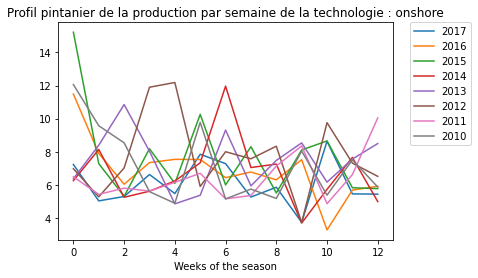

In [32]:
Affichage_annees("onshore", Profils_saisonniers, "printemps")

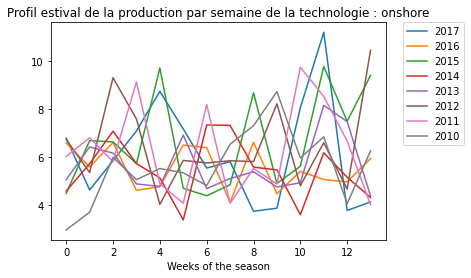

In [33]:
Affichage_annees("onshore", Profils_saisonniers, "ete")

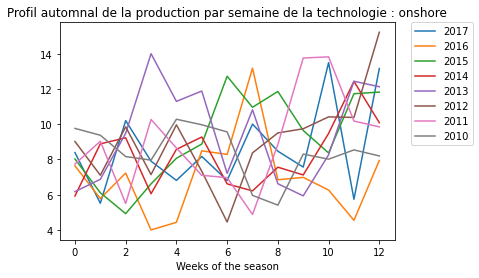

In [34]:
Affichage_annees("onshore", Profils_saisonniers, "automne")

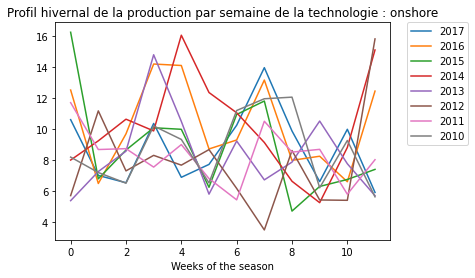

In [35]:
Affichage_annees("onshore", Profils_saisonniers, "hiver")

##### 5.2.3 Profils onhsore annuels

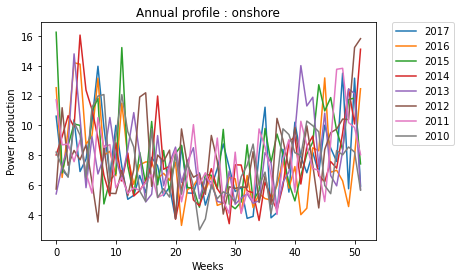

In [36]:
Affichage_annees("onshore", Profils_annuels)

#### 5.3 Profils solaires

##### 5.3.1 Profils solaires journaliers

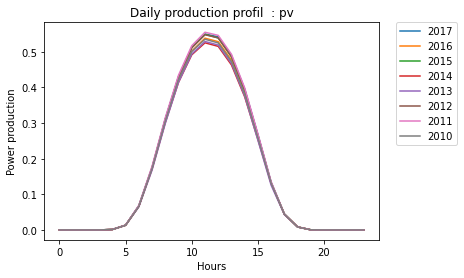

In [37]:
Affichage_annees("pv", Profils_journaliers)

##### 5.3.2 Profils solaires saisonniers

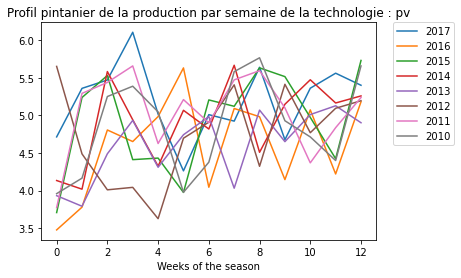

In [38]:
Affichage_annees("pv", Profils_saisonniers, "printemps")

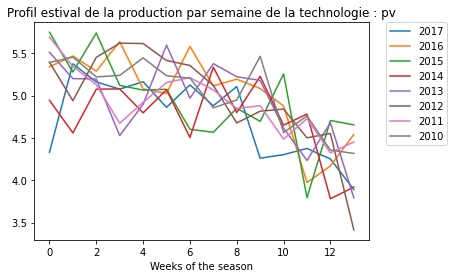

In [39]:
Affichage_annees("pv", Profils_saisonniers, "ete")

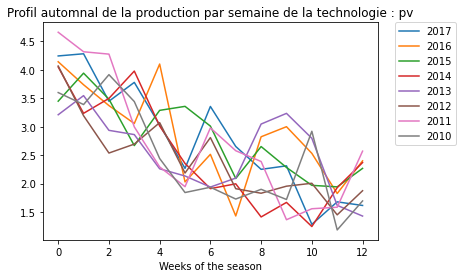

In [40]:
Affichage_annees("pv", Profils_saisonniers, "automne")

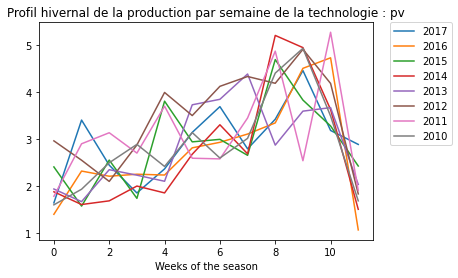

In [41]:
Affichage_annees("pv", Profils_saisonniers, "hiver")

##### 5.3.3 Profils solaires annuels

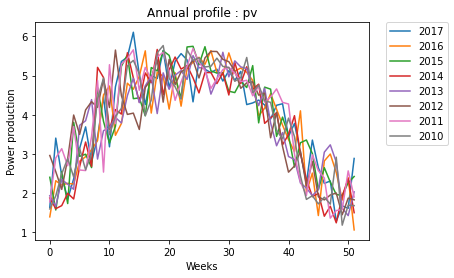

In [42]:
Affichage_annees("pv", Profils_annuels)